In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier, plot_tree, plot_importance
from anchor import anchor_tabular


Load data

In [44]:
df = pd.read_csv("data/mammographic.csv", header=None)
df.columns = ["feat_1", "feat_2", "feat_3", "feat_4", "feat_5", "class"]
df.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,class
0,0.090909,0.628205,0.666667,1.00,0.666667,1.0
1,0.090909,0.512821,1.000000,1.00,0.666667,1.0
2,0.072727,0.128205,0.000000,0.00,0.666667,0.0
3,0.090909,0.500000,0.000000,1.00,0.666667,1.0
4,0.090909,0.743590,0.000000,0.75,0.666667,1.0


In [45]:
df["class"].value_counts()

0.0    427
1.0    403
Name: class, dtype: int64

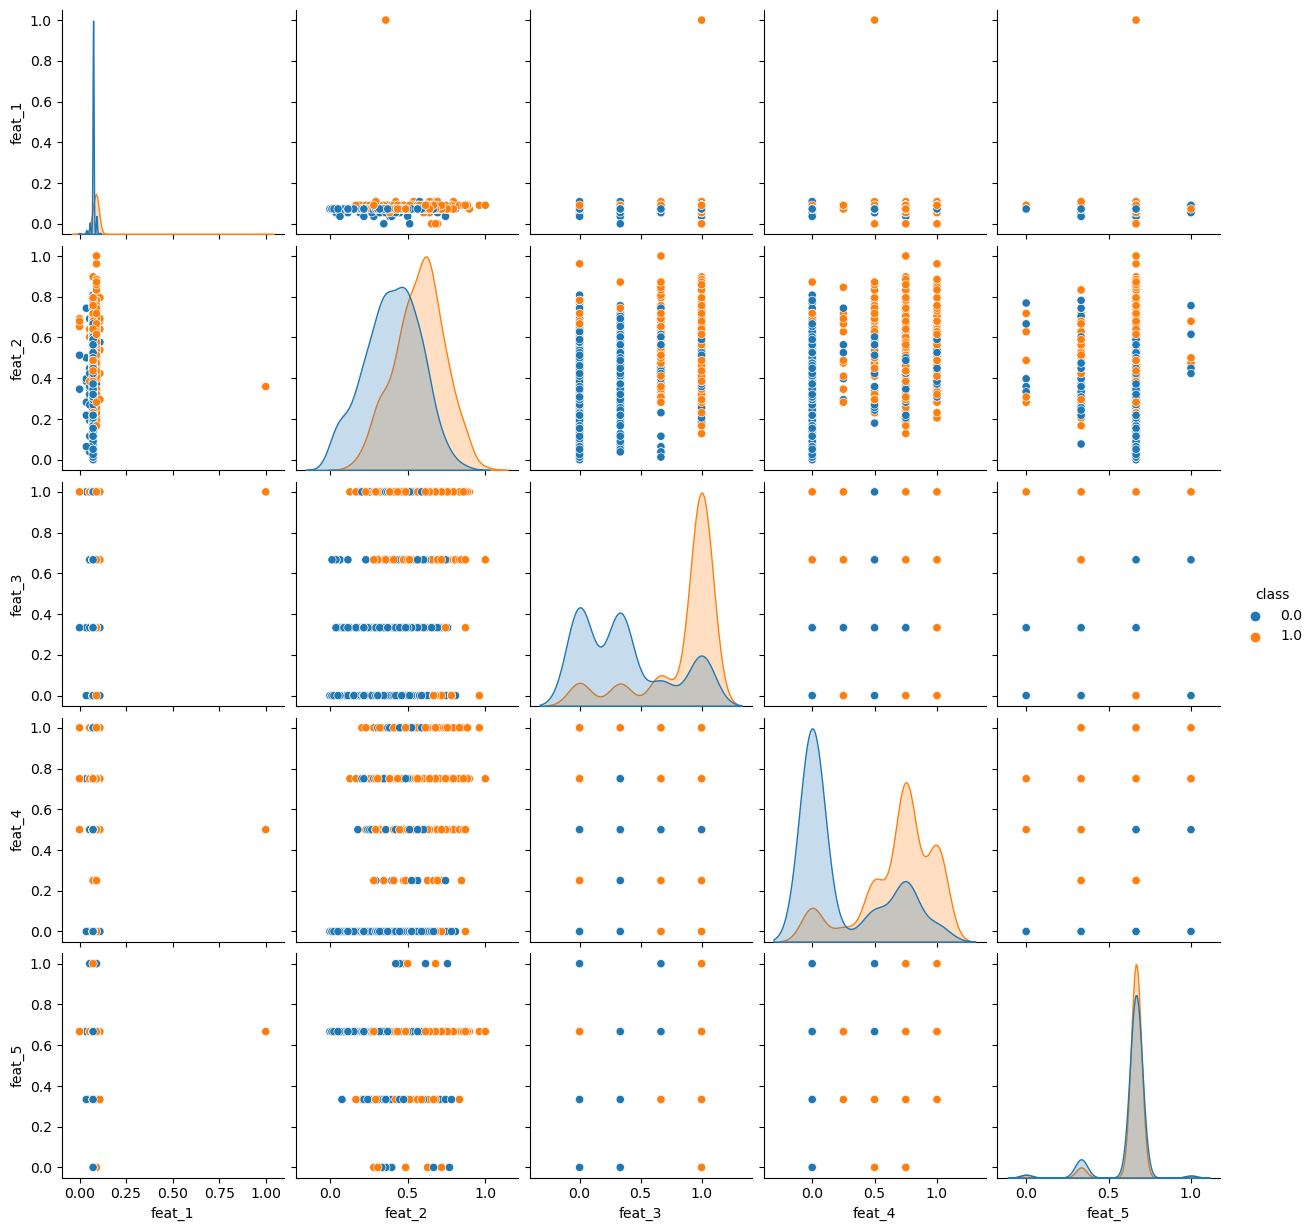

In [46]:
sns.pairplot(df, hue="class")
plt.show()

In [47]:
X = df.drop(columns=["class"])
y = df.loc[:, "class"]
X.shape, y.shape

((830, 5), (830,))

XGBOOST

In [49]:
model = XGBClassifier(max_depth=4, max_leaves=10)
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=10,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [50]:
preds = model.predict(X)

for metric in [accuracy_score, roc_auc_score, f1_score]:
    print(metric(y, preds))

0.8903614457831325
0.8903045658730481
0.8872366790582402


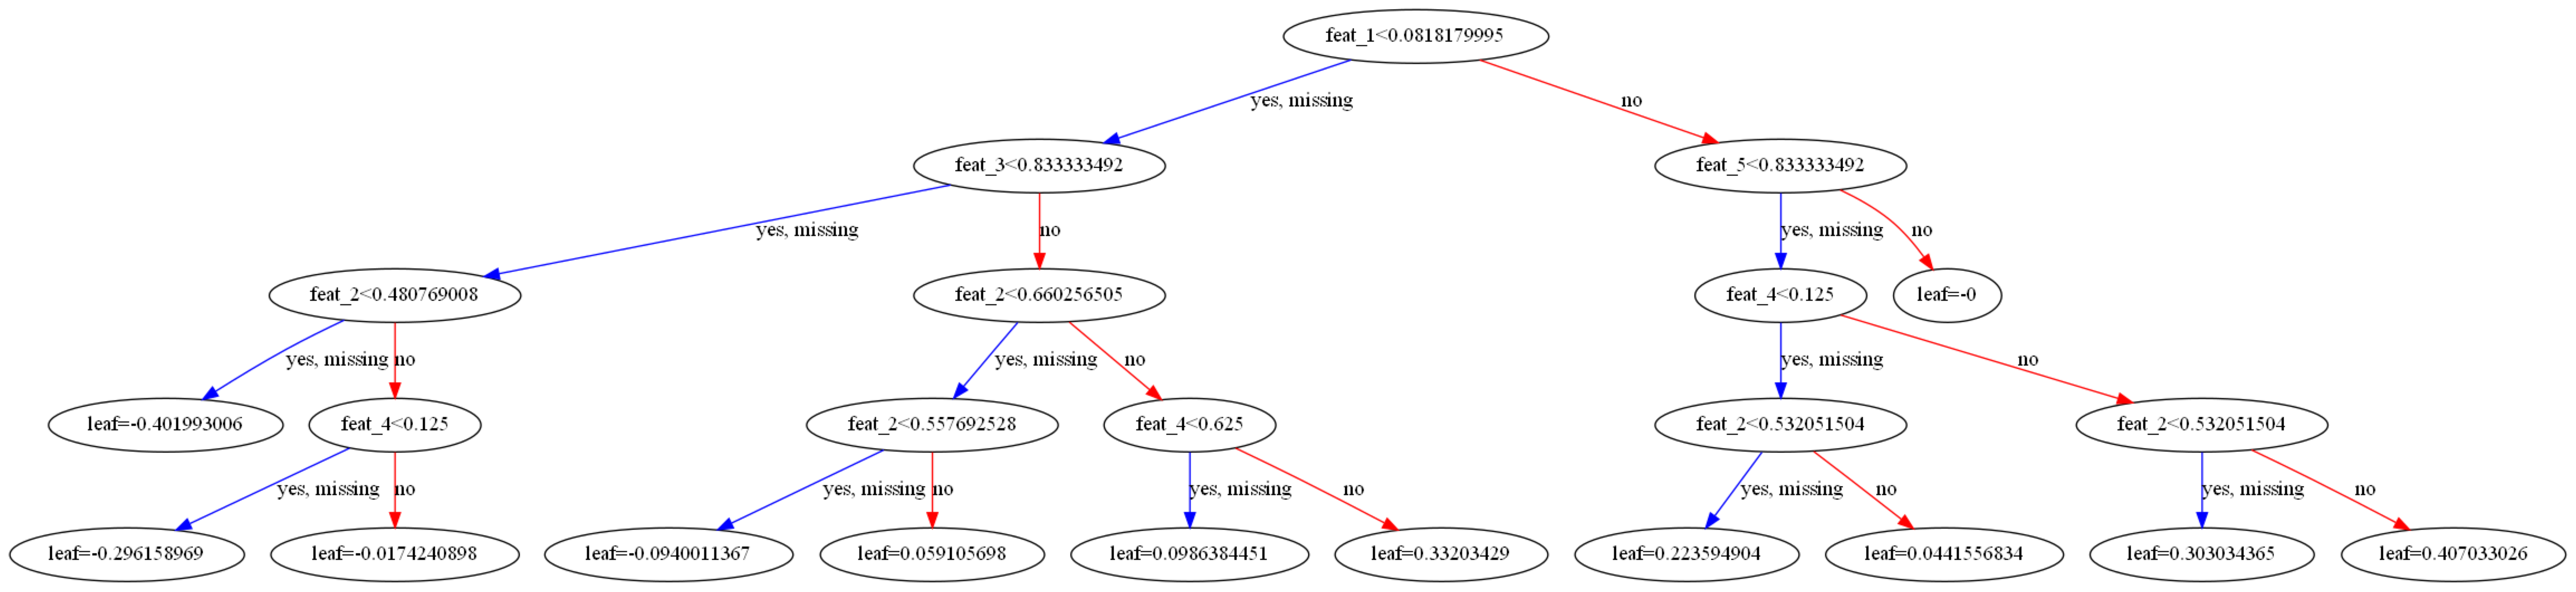

In [51]:
fig, ax = plt.subplots(figsize=(80, 100))
plot_tree(model, ax=ax, num_trees=1)
plt.show()

Liście zawierają oszacowania z ich odpowiedniego uczenia bazowego w dziedzinie funkcji, w której odbywa się procedura wzmacniania gradientowego. W przypadku przedstawionego zadania klasyfikacji binarnej zastosowanym powiązaniem jest logit, więc te szacunki reprezentują szanse logarytmiczne. Aby uzyskać szacunki prawdopodobieństwa, po prostu używamy funkcji logistycznej $\frac{1}{1+e^{-leafvalue}}$. Dla wartości liścia równego 0 otrzymamy równe prawdopodobięństwo przynależności do klas. Wartości mniejsze od zera wskazują na klasę negatywną (w naszym przypadku, klasę z etykietą równą 0), a wartości większę od zera w liściu dają większe prawdopodbienstwo klasie pozytywnej (klasie z etykietą równą 1).

Analizująć drzewo decyzyjne, możemy wyróżnić trzy poddrzewa. W lewej stronie wykresu poniżej warunku `feat_2 < 0.48` wszystkie liściue mają wartości ujemne, przez co w tej części drzewa zwrócona zostanie klasa negatywna (z większym bądź mniejszym prawdopodbieństwem). W prawej częsci drzewa prawie zawsze zostanie zwrócona klasa pozytywna (z wyjątkiem jednego liścia gdzie znajdziemy równe prawdopodbięnstwo dla obu klas). Środkowa część drzewa, dla warunku `feat_3 < 0.83` i odpowiedź `no` zwracana jest zarówno klasa negatywana jak i klasa pozytywna.

Możemy zatem stweirdzić, że dla wartości `feat_1` powyżej wartości 0.08 zwrócona zostanie klasa pozytywna, natomiast dla przykładów, które na `feat_1` mają wartości mniejsze niż 0.08 oraz na `feat_3` mają wartości mniejsze od 0.83, zwrócona zostanie klasa negatywna. W pozostałych przypadkach może zostać zwrócona klasa pozytywna jak i negatywna,w zależności od wartości na kryterium `feat_2`.

Analizując atrybuty wykorzystane do klasyfikacji, można wyodrębnić kryteria które mają wpływ decydujący, oraz kryteria które nie maja żadnego wpływu na decyzje. Do tej pierwszej grupy zaliczymy kryteria: `feat_1`, `feat_3` oraz `feat_2`. Natomiast w drugiej grupie znajdizemy `feat_5` oraz `feat_4`, które znajdują się w podrzewach dla których liscie zwracają jedną klasą, ale z różnymi prawdopodbieństwami. Przez co wartości na tych kryteriach nie zmienią decyzji modelu.

In [52]:
# TODO: Czy istnieją jakieś progi preferencji?
# • Czy istnieją oceny kryteriów, które są nierozróżnialne z punktu widzenia preferencji?

Ważność cech

Analiza cech została wykonana z wykorzystaniem dwóch metod. `plot_importance` z pakietu `xgboost` wskazuje na to ile razy dana cecha została wykorzystana do przeprowadzenia operacji podziału w drzewie decyzyjnym. Możemy zauważyć, że w tym wypadku była to głównia `feat_2`. Analizując drzewo decyzyjne opisane w poprzednimpunkcie możemy zauważyć, że kryterium to najczęsciej występuje na wykresie. `feat_4` oraz `feat_3` było wykorzystywane w podobnym stopniu. Troche mniej razy skorzytsaliśmy z `feat_1` oraz `feat_5`. To pierwsze kryterium znajduje się w korzeniu naszego drzewa i mocno wpływa na decyzje modelu.

Analiza przeprowadzona z wykorzytsaniem `permutation_importance` polega na zamianie wartości jednej cechy na losowe wartości i obserwacji, jak bardzo to wpływa na wydajność modelu. Widzimy, że model jest nbajbardziej czuły na zmianę wartości kryterium `feat_1`. Nie jest to zaskoczeni, gdyż właśnie to kryterium znajduje się w korzeniu drzewa decyzyjnego. Najmniej na zmianę decyzji modelu wpływa modyfikacja na kryterium `feat_5`, który w poprzednim punkcie zostało opisane jak kryterium nie wpływająca na decyzje modelu.

Przeprowadzone analizy pokrywają się częściowo z wnioskami z poprzedniego punktu.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

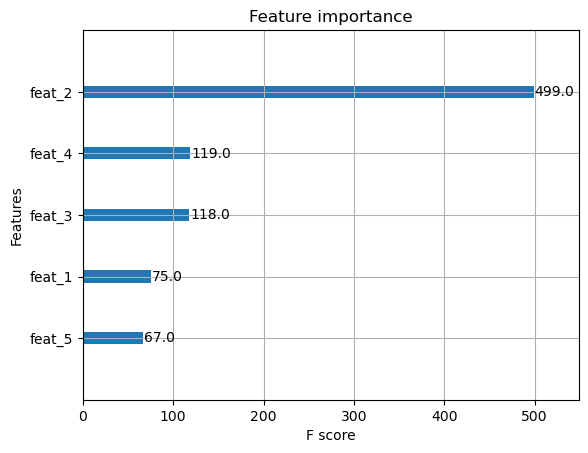

In [53]:
plot_importance(model)

<Axes: >

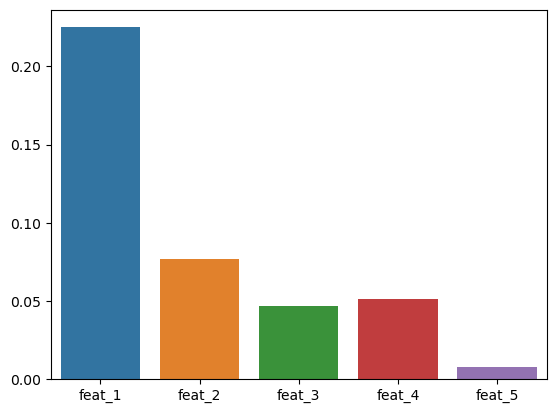

In [54]:
result = permutation_importance(model, X, y, n_repeats=10, random_state=0)
sns.barplot(x=X.columns, y=result["importances_mean"])

3 warianty

In [81]:
examples = df.sample(3, random_state=1).copy()
examples

,feat_1,feat_2,feat_3,feat_4,feat_5,class
786,0.072727,0.423077,0.000000,0.00,0.666667,0.0
522,0.072727,0.628205,0.333333,0.00,0.666667,0.0
811,0.090909,0.512821,0.666667,0.75,0.666667,1.0


In [82]:
model.predict(examples.drop(columns=["class"]))

array([0, 0, 1])

In [83]:
examples.iloc[0:2, 0] += 0.015
examples.iloc[2, 0] -= 0.015
examples

,feat_1,feat_2,feat_3,feat_4,feat_5,class
786,0.087727,0.423077,0.000000,0.00,0.666667,0.0
522,0.087727,0.628205,0.333333,0.00,0.666667,0.0
811,0.075909,0.512821,0.666667,0.75,0.666667,1.0


In [84]:
model.predict(examples.drop(columns=["class"]))

array([1, 1, 0])

Dla wybranych trzechg przykładów model zaklasyfikował dwa pierwsze warinaty do klasy 0 a trzeci wariant do klasy 1. Po dodaniu wartości 0.015 do `feat_1` dla dwóch pierwszych wariantów i odjęcie 0.15 od `feat_1` dla trzeceig warinatu odwraca predykcje modelu. Model jest czuły na zmianę wartości kryterium `feat_1` co pokzała analiza `permutation_importance`.

In [58]:
explainer = anchor_tabular.AnchorTabularExplainer(["0", "1"], X.columns, X.to_numpy())

In [59]:
for i, (_, example) in enumerate(examples.iterrows()):
    print(f"Example {i+1}: {list(example)}")
    example = pd.DataFrame(example).T.drop(columns=["class"]).reset_index(drop=True)
    exp = explainer.explain_instance(example.to_numpy(), model.predict, threshold=0.95)
    print('\tPrediction: ', explainer.class_names[model.predict(example).reshape(1, -1)[0][0]])
    print('\tAnchor: %s' % (' AND '.join(exp.names())))
    print('\tPrecision: %.2f' % exp.precision())
    print('\tCoverage: %.2f' % exp.coverage())

Example 1: [0.090909, 0.410256, 0.666667, 0.25, 0.666667, 1.0]
	Prediction:  1
	Anchor: feat_1 > 0.07 AND feat_4 > 0.00
	Precision: 0.99
	Coverage: 0.37
Example 2: [0.090909, 0.846154, 1.0, 1.0, 0.666667, 0.0]
	Prediction:  1
	Anchor: feat_1 > 0.07 AND feat_3 > 0.33
	Precision: 0.99
	Coverage: 0.35
Example 3: [0.072727, 0.628205, 1.0, 0.75, 0.666667, 1.0]
	Prediction:  1
	Anchor: feat_2 > 0.62 AND feat_3 > 0.67
	Precision: 0.98
	Coverage: 0.16
